In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
tongpython_cat_and_dog_path = kagglehub.dataset_download('tongpython/cat-and-dog')

print('Data source import complete.')


Using Colab cache for faster access to the 'cat-and-dog' dataset.
Data source import complete.



# 1) Imports


In [2]:
!pip install --upgrade protobuf==3.20.*


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.3 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
ydf 0.14.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.


In [6]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image  # <--- 이 줄이 추가되어야 합니다!
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
import warnings
warnings.filterwarnings("ignore")

# 2) load File Paths (Cats / Dogs)

In [4]:

train_path = "/kaggle/input/cat-and-dog/training_set/training_set"
test_path  = "/kaggle/input/cat-and-dog/test_set/test_set"

cats_train_dir = os.path.join(train_path, "cats")
dogs_train_dir = os.path.join(train_path, "dogs")

cats_test_dir = os.path.join(test_path, "cats")
dogs_test_dir = os.path.join(test_path, "dogs")

print("Number of training cat images:", len(os.listdir(cats_train_dir)))
print("Number of training dog images:", len(os.listdir(dogs_train_dir)))
print("Number of testing cat images:", len(os.listdir(cats_test_dir)))
print("Number of testing dog images:", len(os.listdir(dogs_test_dir)))

Number of training cat images: 4001
Number of training dog images: 4006
Number of testing cat images: 1012
Number of testing dog images: 1013



# 3) Display random sample images from Train


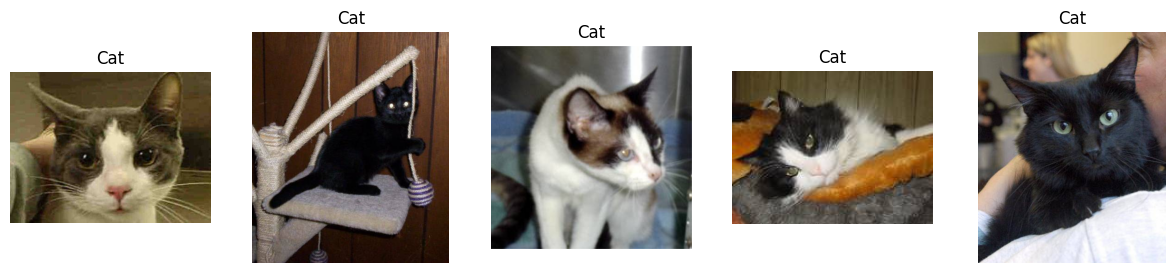

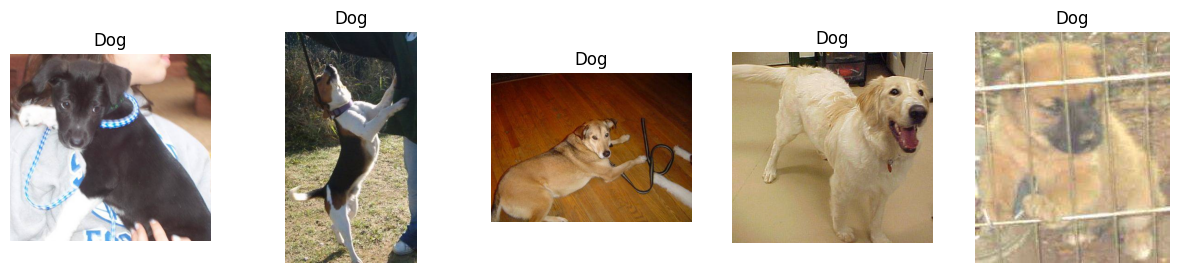

In [7]:

def show_samples(folder, label, n=5):
    plt.figure(figsize=(15,3))
    sample_files = random.sample(os.listdir(folder), n)
    for i, img_name in enumerate(sample_files):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

show_samples(cats_train_dir, "Cat")
show_samples(dogs_train_dir, "Dog")



# 4) Load images safely


In [8]:
IMG_SIZE = 128
BATCH_SIZE = 32

# 훈련 및 검증 데이터셋 자동 로드 및 분할
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Class names:", class_names)

# 성능 최적화를 위한 프리페치(Prefetch)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Found 8005 files belonging to 2 classes.
Using 1601 files for validation.
Class names: ['cats', 'dogs']



# 7) Data Augmentation


In [12]:
# 7) Data Augmentation (현대적인 방식)
# 모델 내부나 데이터셋에 바로 적용할 수 있는 증강 레이어입니다.

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), # 좌우 반전
    tf.keras.layers.RandomRotation(0.1),      # 10% 회전
    tf.keras.layers.RandomZoom(0.1),          # 10% 확대/축소
])

# 이 data_augmentation은 나중에 모델(Sequential)의 첫 번째 레이어로 넣을 겁니다.


# 8) Build CNN Model


In [13]:
model = Sequential([
    # 1. 입력 전처리 및 증강
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation,         # <--- 방금 만든 증강 레이어 추가!
    Rescaling(1./255),         # 0~255를 0~1로 정규화

    # 2. 특징 추출 (CNN)
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 학습 시작
history = model.fit(
    train_ds,
    epochs=60,
    validation_data=val_ds,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)]
)

Epoch 1/60
  8/201 ━━━━━━━━━━━━━━━━━━━━ 3:37 1s/step - accuracy: 0.4677 - loss: 3.8411

KeyboardInterrupt: 


# 12) Plot Accuracy & Loss


In [ ]:

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()



# 13) Prepare Test Dataset


In [ ]:

X_test, y_test = [], []
def is_image_file(filename):
    return filename.lower().endswith(('.png', '.jpg', '.jpeg'))


for f in os.listdir(cats_test_dir):
    if is_image_file(f):
      img = Image.open(os.path.join(cats_test_dir, f)).resize((IMG_SIZE, IMG_SIZE))
      X_test.append(np.array(img))
      y_test.append(0)

for f in os.listdir(dogs_test_dir):
   if is_image_file(f):
    img = Image.open(os.path.join(dogs_test_dir, f)).resize((IMG_SIZE, IMG_SIZE))
    X_test.append(np.array(img))
    y_test.append(1)

X_test = np.array(X_test) / 255.0
y_test = np.array(y_test)

print("Test Dataset shape:", X_test.shape, y_test.shape)



# 14) Evaluate Model on Test Dataset


In [ ]:

loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)


# 15) Try model on test images

In [ ]:
def predict_multiple_images(n=5):
    indices = random.sample(range(len(X_test)), n)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_label = "Cat" if y_test[idx] == 0 else "Dog"

        pred = model.predict(img.reshape(1, IMG_SIZE, IMG_SIZE, 3))
        pred_label = "Cat" if np.argmax(pred) == 0 else "Dog"

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"T:{true_label}\nP:{pred_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
predict_multiple_images(5)


In [ ]:
# 모델 저장 (파일명은 자유롭게 수정하세요)
model.save('dog_cat_cnn_model.keras')
print("모델 저장 완료: dog_cat_cnn_model.keras")

# 필요할 때 다시 불러오는 법:
# from tensorflow.keras.models import load_model
# model = load_model('dog_cat_cnn_model.keras')

In [ ]:
# 첫 번째 Conv2D 레이어의 출력을 가져오는 모델 생성
visual_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[2].output) # Index 2가 보통 첫 Conv2D

# 테스트 데이터셋에서 이미지 하나 가져오기
for images, labels in test_ds.take(1):
    img = images[0:1] # 첫 번째 이미지
    feature_maps = visual_model.predict(img)
    
    # 8x4 그리드로 첫 32개 필터 결과 시각화
    plt.figure(figsize=(16, 8))
    for i in range(32):
        plt.subplot(4, 8, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle("First Conv Layer - Feature Maps (What the model 'sees')")
    plt.show()
    break

In [ ]:
def plot_prediction_results(dataset, n=6):
    plt.figure(figsize=(18, 10))
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        for i in range(n):
            plt.subplot(2, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            prob = np.max(preds[i]) * 100
            pred_idx = np.argmax(preds[i])
            true_idx = labels[i].numpy()
            
            color = 'blue' if pred_idx == true_idx else 'red'
            plt.title(f"True: {class_names[true_idx]}\nPred: {class_names[pred_idx]} ({prob:.1f}%)", color=color)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_prediction_results(test_ds)